In [3]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

def solveBE_heateq1D(fs, ic, a, L, dt, F, T):
    """
    Vectorized implementation of solver_BE_simple using also
    a sparse (tridiagonal) matrix for efficiency.
    """
    n = fs.shape[2]
    Nt = int(round(T/float(dt))) + 1
    t = np.linspace(0, (Nt-1)*dt, Nt)   # Mesh points in time
    dx = np.sqrt(a*dt/F)
    Nx = int(round(L/dx)) + 1
    x = np.linspace(0, L, Nx)       # Mesh points in space
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    
    us = np.zeros((Nx, Nt, n))   # solution array
    
    # Representation of sparse matrix and right-hand side
    diagonal = np.zeros(Nx)
    lower    = np.zeros(Nx-1)
    upper    = np.zeros(Nx-1)
    b        = np.zeros(Nx)

    # Precompute sparse matrix
    diagonal[:] = 1 + 2*F
    lower[:] = -F  #1
    upper[:] = -F  #1
    # Insert boundary conditions
    diagonal[0] = 1
    upper[0] = 0
    diagonal[Nx-1] = 1
    lower[-1] = 0

    A = sparse.diags(
        diagonals=[diagonal, lower, upper],
        offsets=[0, -1, 1], shape=(Nx, Nx),
        format='csr')

    for i in range(Nt-1):
        b = us[:, i, :] + dt*fs[:, i+1, :]
        b[0] = b[-1] = 0.0  # boundary conditions
        us[:, i+1, :] = spsolve(A, b)
    return us

In [48]:
from karhunen_loeve import general_radial_kle

# heat equation parameters
L = 1
T = 1
a = 0.1

# number of samples
n = 1000

# number of modes in KLE
modes = 1000

# width of radial kernel
kernel_widths = [1e-2, 2.5e-2, 5e-2, 7.5e-2, 1e-1, 2.5e-1, 5e-1, 7.5e-1, 1.0, 2.5, 5.0, 7.5, 10.0]

# mesh sizes for forcing and solution
#mesh_sizes = [20, 25, 30, 35, 40, 45, 50]
mesh_sizes = [50, 75, 100, 125, 150]

In [49]:
import h5py

# generate exponential KLE forcing and solutions for heat equation
file = h5py.File("heateq_exponentialKLE.hdf5", "a")
for m in mesh_sizes:
    mx = mt = m
    dx = L/(mx-1)
    dt = T/(mt-1)
    F = a*dt/(dx**2)
    ic = np.zeros(mx)
    print(f"Mesh Size: {m}")
    
    mesh_grp = file.require_group(f"mesh{m}")
    x_mesh = np.linspace(0, L, mx)
    t_mesh = np.linspace(0, T, mt)
    mesh = np.meshgrid(x_mesh, t_mesh)
    mesh_grp.attrs["mesh"] = (x_mesh, t_mesh)
    
    modes = np.prod(mesh[0].shape)
    for kernel_width in kernel_widths:
        kernel_width_grp = mesh_grp.require_group(f"kernelwidth{kernel_width}")
        kernel = lambda x: np.exp(-np.abs(x)/kernel_width)
        fs = general_radial_kle(mesh, n, modes, f=kernel)
        fs_dset = kernel_width_grp.create_dataset("forcings", data=fs.reshape(m**2, -1).T)

        us = solveBE_heateq1D(fs, ic, a, L, dt, F, T)
        us_dset = kernel_width_grp.create_dataset("solutions", data=us.reshape(m**2, -1).T)

file.close()
del file

Mesh Size: 50
Mesh Size: 75
Mesh Size: 100
Mesh Size: 125
Mesh Size: 150


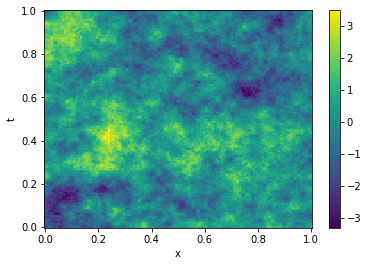

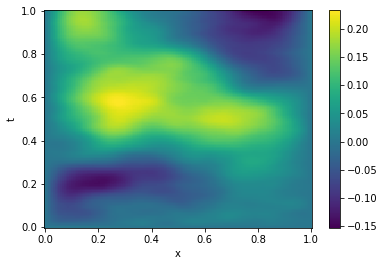

In [51]:
import matplotlib.pyplot as plt

m = 150
kernel_width = 0.1

data = h5py.File("../generate_data/heateq_exponentialKLE.hdf5", "r")
mesh = data[f"mesh{m}"].attrs["mesh"]

fs = data[f"mesh{m}"][f"kernelwidth{kernel_width}"]["forcings"]
us = data[f"mesh{m}"][f"kernelwidth{kernel_width}"]["solutions"]

i = 60

plt.pcolormesh(mesh[1], mesh[0], fs[i, :].reshape(m, m).T, shading="nearest")
plt.xlabel("x")
plt.ylabel("t")
plt.colorbar()
plt.show()

plt.pcolormesh(mesh[1], mesh[0], us[i, :].reshape(m, m).T, shading="nearest")
plt.xlabel("x")
plt.ylabel("t")
plt.colorbar()
plt.show()